<font size="5.5">**Using Transformer-based Deep Learning Methods to address theConstruct Identity Problem in Information Systems Research andLiterature Reviews**</font> <br>
Masterthesis by Fabian Längle

<font size="4.5"> **Table of Contents**</font>

* [Initialization](#Initialization)
    * [Install and import relevant libraries](#intro)
    * [Function definition](#func_def)
        * [Artifact-specific functions](#art_func)
        * [General functions by Ludwig et al. (2020)](#general_func)
    * [Variable and data definition](#var_def)
    * [Load data](#load)
* [Data augmentation](#aug)
* [Fine-tuning language model](#ft)
    * [Plot training history](#plot)
* [Extract features from transformer model](#extract)
    * [Plot results as ROC curve](#roc)
    * [Compare models on item level](#compare)
    * [Visualize attention](#attention)
* [LSA and GloVe by Ludwig et al. (2020)](#lsa)
* [LSA and GloVe using augmented text corpus](#lsa_aug)
* [Appendix](#app)


# Initialization

Install and import relevant packages/libraries. Define custom functions.

## Install and import relevant libraries <a name="intro"></a>

In [14]:
# install stemming
!pip install --user git+https://github.com/JonathanRaiman/glove.git

  Cloning https://github.com/JonathanRaiman/glove.git to /tmp/pip-req-build-26flmk08
  Running command git clone -q https://github.com/JonathanRaiman/glove.git /tmp/pip-req-build-26flmk08
  Created wheel for glove: filename=glove-1.0.1-cp36-none-any.whl size=4999 sha256=7acfd99755fb15a13170f4f998f7dd1af4a387e9da93c461c5152fbab3b780fa
  Stored in directory: /tmp/pip-ephem-wheel-cache-t4e_idq9/wheels/e4/ea/7c/0e887c01470d73c6b0f3395891804fc2923caca44dd76cdedc
Successfully built glove


In [15]:
# install nlpaug
!pip install --user nlpaug numpy matplotlib python-dotenv

In [16]:
# Install BertViz
!test -d bertviz_repo && echo "FYI: bertviz_repo directory already exists, to pull latest version uncomment this line: !rm -r bertviz_repo"
!test -d bertviz_repo || git clone https://github.com/jessevig/bertviz /home/jupyter-laengle/github_repos/bertviz
!pip install regex

fatal: destination path '/home/jupyter-laengle/github_repos/bertviz' already exists and is not an empty directory.


In [1]:
import sklearn
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import SGDClassifier
from tqdm.notebook import tqdm
from IPython.display import display
from stemming.porter2 import stem as stem_porter2
from stemming.paicehusk import stem as stem_paicehusk

import gc
import tqdm.notebook as tqdm
import os.path
import warnings
import csv
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import glove
import torch
import tensorflow as tf
import transformers
import nlpaug.augmenter.word as naw
import pickle
import warnings
warnings.filterwarnings('ignore')
np.set_printoptions(threshold=3000)
pd.options.display.max_colwidth = 200
%cd github_repos/bertviz
from bertviz.transformers_neuron_view import BertModel, BertTokenizer
from bertviz.neuron_view import show


/home/jupyter-laengle/github_repos/bertviz


## Function definition <a name="func_def"></a>

First, we initialize the functions defined by Ludwig et al. (2020) which we assume for the present work. Then we define functions specifically for this work. 

### Artifact-specific functions <a name="art_func"></a>

In [2]:
def bert_sentence_embedding(sentences, model='BERT', model_dir='', pool_strategy='concat_4'):
    
    """
    Creates sentence embeddings based on raw sentence inputs (e.g. corpus_items) by applying either 
    BERT_base (by Google), DistilBERT (by HuggingFace), RoBERTa (by Facebook) or AlBERT (by Google).
    Model output is aggregated to sentence representations.

    Parameters:
      sentences: list of input sequences
      model: BERT, Roberta, DistilBERT, ALBERT, SciBERT, custom_bert, custom_roberta, custom_distilbert, custom_albert
      model_dir: directory to custom fine-tuned model
      pool_strategy: CLS, concat_4, sum_4, second_to_last, sum_all, last_layer
    
    """
    print('Loading ' + model + ' model...')
    if model == 'BERT':
        model_class, tokenizer_class, config_class, pretrained_weights = (transformers.BertModel, 
                                                                          transformers.BertTokenizer, 
                                                                          transformers.BertConfig, 
                                                                          'bert-base-uncased')
    elif model == 'Roberta':
        model_class, tokenizer_class, config_class, pretrained_weights = (transformers.RobertaModel, 
                                                                          transformers.RobertaTokenizer, 
                                                                          transformers.RobertaConfig, 
                                                                          'roberta-base')
    elif model == 'Distilbert':
        model_class, tokenizer_class, config_class, pretrained_weights = (transformers.DistilBertModel, 
                                                                          transformers.DistilBertTokenizer, 
                                                                          transformers.DistilBertConfig, 
                                                                          'distilbert-base-uncased')
    elif model == 'Albert':
        model_class, tokenizer_class, config_class, pretrained_weights = (transformers.AlbertModel, 
                                                                          transformers.AlbertTokenizer, 
                                                                          transformers.AlbertConfig, 
                                                                          'albert-base-v1')
    elif model == 'scibert':
        model_class, tokenizer_class, config_class, pretrained_weights = (transformers.BertModel, 
                                                                          transformers.BertTokenizer, 
                                                                          transformers.BertConfig, 
                                                                          'allenai/scibert_scivocab_uncased')      
    elif model == 'custom_bert':
        model_class, tokenizer_class, config_class, pretrained_weights = (transformers.BertModel, 
                                                                          transformers.BertTokenizer, 
                                                                          transformers.BertConfig, 
                                                                          model_dir) 
    elif model == 'custom_roberta':
        model_class, tokenizer_class, config_class, pretrained_weights = (transformers.RobertaModel, 
                                                                          transformers.RobertaTokenizer, 
                                                                          transformers.RobertaConfig, 
                                                                          model_dir) 
    elif model == 'custom_distilbert':
        model_class, tokenizer_class, config_class, pretrained_weights = (transformers.DistilBertModel, 
                                                                          transformers.DistilBertTokenizer, 
                                                                          transformers.DistilBertConfig, 
                                                                          model_dir) 
    elif model == 'custom_albert':
        model_class, tokenizer_class, config_class, pretrained_weights = (transformers.AlbertModel, 
                                                                          transformers.AlbertTokenizer, 
                                                                          transformers.AlbertConfig, 
                                                                          model_dir)   
    else:
        model_class, tokenizer_class, config_class, pretrained_weights = (transformers.BertModel, 
                                                                          transformers.BertTokenizer, 
                                                                          transformers.BertConfig, 
                                                                          'bert-base-uncased')
        
    tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
    config = config_class.from_pretrained(pretrained_weights, output_hidden_states=True)
    model = model_class.from_pretrained(pretrained_weights, config=config)

    sentences = np.array(sentences)
    
    # tokenize the sentences: break up into words + subwords, add special tokens (e.g. [CLS] and [SEP])
    print('Tokenizing corpus...')   
    input_ids = []
    attention_masks = []

    for sent in sentences:
        encoded_dict = tokenizer.encode_plus(
                                sent,                           
                                add_special_tokens = True,      # Add special tokens like '[CLS]' and '[SEP]',
                                max_length = 64,                
                                pad_to_max_length = True,
                                return_attention_mask = True,   
                                return_tensors = 'pt',          
                        )
    
        # Add the encoded sentence to list.    
        input_ids.append(encoded_dict['input_ids'])
        
        # Add attention mask.
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert list to tensors
    print('Create tensors...')
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    # set model to evaluation mode in order to turn off dropout regularization 
    model.eval()

    print('Run model...')
    with torch.no_grad():
        hidden_states = model(input_ids=input_ids, attention_mask=attention_masks) 

    # Get hidden layers as one tensor
    if model_name in ['Distilbert', 'custom_distilbert']:
        token_embeddings = torch.stack(hidden_states[1], dim=0)
    else:
        token_embeddings = torch.stack(hidden_states[2], dim=0)

    # Rearrange token embeddings for pooling into desired order: items, tokens, layers, embedding
    token_embeddings_rearranged = token_embeddings.permute(1,2,0,3)

    # Document projection strategies
    if pool_strategy == 'CLS':
        sent_embeddings = hidden_states[0][:,0,:].numpy()
    elif pool_strategy == 'concat_4':
        sent_embeddings = concat_4(token_embeddings_rearranged)
    elif pool_strategy == 'sum_4':
        sent_embeddings = sum_4(token_embeddings_rearranged)
    elif pool_strategy == 'second_to_last':
        sent_embeddings = second_to_last(token_embeddings_rearranged)
    elif pool_strategy == 'sum_all':
        sent_embeddings = sum_all(token_embeddings_rearranged)
    elif pool_strategy == 'last_layer':
        sent_embeddings = last_layer(token_embeddings_rearranged)

    return sent_embeddings



def concat_4(token_embeddings):
    """
    concatenate the four last hidden layers of rearranged token embeddings 
    of the format ([sentences, max_tokens, layers, hidden_tokens]).
    E.g. ([451, 33, 13, 768])

    Document projection through aggregation of all tokens into a sentence representation (unweighted centroid)
    """
    # extract the four last hidden layers
    last = token_embeddings.narrow(2, -1, 1)
    second_to_last = token_embeddings.narrow(2, -2, 1)
    third_to_last = token_embeddings.narrow(2, -3, 1)
    fourth_to_last = token_embeddings.narrow(2, -4, 1)
  
    # concatenate last 4 hidden layers. Resulting shape: ([451, 33, 1, 3072])
    aggr_embed_cat_token = torch.cat((last, second_to_last, third_to_last, fourth_to_last), dim=3)

    # document projection through aggregation of all tokens into a sentence representation (unweighted centroid)
    # Resulting shape: ([451, 1, 3072])
    aggr_embed_cat_sent = torch.mean(aggr_embed_cat_token, dim=1)
    # Squeeze tensor to remove redundant dimension. Resulting shape: ([451, 3072])
    aggr_embed_cat_sent_sq = torch.squeeze(aggr_embed_cat_sent)
    return(aggr_embed_cat_sent_sq)



def sum_4(token_embeddings):
    """
    Sum the last four hidden layers of rearranged token embeddings 
    of the format ([sentences, max_tokens, layers, hidden_tokens]).
    E.g. ([451, 33, 13, 768])

    Document projection through aggregation of all tokens into a sentence representation (unweighted centroid)
    """
    # sum last four hidden layers. Resulting shape ([451, 33, 768])
    aggr_embed_sum_token = torch.sum(token_embeddings.narrow(2, -4, 4), dim=2)
    # document projection
    aggr_embed_sum_sent = torch.mean(aggr_embed_sum_token, dim=1)
    return(aggr_embed_sum_sent)



def second_to_last(token_embeddings):
    """
    Extract second-to-last hidden layer of rearranged token embeddings 
    of the format ([sentences, max_tokens, layers, hidden_tokens]).
    E.g. ([451, 33, 13, 768])

    Document projection through aggregation of all tokens into a sentence representation (unweighted centroid)    
    """
    # slice respective layer. Resulting shape:([451, 33, 1, 768])
    aggr_embed_sectolast = token_embeddings.narrow(2, -2, 1)
    # document projection
    aggr_embed_sectolast_sent = torch.squeeze(torch.mean(aggr_embed_sectolast, dim=1))
    return(aggr_embed_sectolast_sent)



def sum_all(token_embeddings):
    """
    Sum all hidden layers of rearranged token embeddings 
    of the format ([sentences, max_tokens, layers, hidden_tokens]).
    E.g. ([451, 33, 13, 768])
    
    Document projection through aggregation of all tokens into a sentence representation (unweighted centroid)
    """
    # Sum up 12 hidden layers. Resulting shape:([451, 33, 768])
    aggr_embed_sum_all_token = torch.sum(token_embeddings.narrow(2, 1, 12), dim=2)
    # document projection
    aggr_embed_sum_all_sent = torch.mean(aggr_embed_sum_all_token, dim=1)
    return(aggr_embed_sum_all_sent)



def last_layer(token_embeddings):
    """
    Extract last hidden layer of rearranged token embeddings 
    of the format ([sentences, max_tokens, layers, hidden_tokens]).
    E.g. ([451, 33, 13, 768])
    
    Document projection through aggregation of all tokens into a sentence representation (unweighted centroid)
    """
    # slice respective layer. Resulting shape:([451, 33, 1, 768])
    aggr_embed_last_token = token_embeddings.narrow(2, -1, 1)
    # document projection
    aggr_embed_last_sent = torch.squeeze(torch.mean(aggr_embed_last_token, dim=1))
    return(aggr_embed_last_sent)



def augment_data(data, alpha=0.1, n=4, k=10):
    '''
    Takes a list of sentences and augements every sentence n times using substitution and insertion 
    based on contextual word embeddings by BERT-base-uncased. 
    Parameters alpha and n are preset with the recommendation elaborated by Wei & Zou (2019)
    Parameters:
      alpha: Percentage of word will be augmented
      n: Number of unique augmented output
      k: Top k score token will be used for augmentation    
    '''
    # Initialize output file
    data_aug = []
    # prepare n for number of augmentation strategies
    n = int(n/2)
    
    # print('Loading model for contextual embeddings...')
    # create substitue augmenter
    aug_sub = naw.ContextualWordEmbsAug(model_path='bert-base-uncased', action='substitute', 
                                        aug_p=alpha, top_k=k, skip_unknown_word=True)
    # create insertion augmenter
    aug_ins = naw.ContextualWordEmbsAug(model_path='bert-base-uncased', action='insert', 
                                        aug_p=alpha, top_k=k, skip_unknown_word=True)

    # iterate through input sentences
    for sentence in data:
        # augmented sentences
        sent_aug_sub = aug_sub.augment(sentence, n=n)
        sent_aug_ins = aug_ins.augment(sentence, n=n)    
        data_aug.append(sentence)
        data_aug.extend(sent_aug_sub)
        data_aug.extend(sent_aug_ins)

    return(data_aug)



def augment_glove_data(df):
    '''
    Augments data for GloVe model.
    Takes a full gold_items DataFrame (including metadata) and dublicates each item 4 times and augments there text.
    Afterwards, ItemOrder and ItemId for every item get updated
   
    Parameters:
        df: Gold items as dataframe including all metadata
    '''
    # Copy each row 5 times
    df_4_fold = df.loc[df.index.repeat(5)].reset_index(drop=True)
    # iterate through all data in index steps of 5
    # take first sentence, augment it and replace four following duplicates with augmented sentences
    for i in tqdm.tqdm(range(0, len(df_4_fold), 5)):
        sentence_aug = augment_data([df_4_fold.iloc[i].Text])
        try:
            df_4_fold.set_value(i+1, 'Text', sentence_aug[1])    
            df_4_fold.set_value(i+2, 'Text', sentence_aug[2])
            df_4_fold.set_value(i+3, 'Text', sentence_aug[3])    
            df_4_fold.set_value(i+4, 'Text', sentence_aug[4])
        except IndexError:
            continue
    # reset the ItemOrder per VariableId for new sentences    
    # reset ItemId
    df_4_fold = df_4_fold.drop(['ItemOrder'], axis=1)
    df_4_fold = df_4_fold.drop(['ItemId'], axis=1)
    df_4_fold['ItemOrder'] = df_4_fold.groupby('VariableId').cumcount()+1
    df_4_fold.insert(0, 'ItemId', np.arange(1, len(df_4_fold)+1))
    return(df_4_fold)



def drop_empty_text(df):
    '''
    Drop items which are too short to be considered for similarity.
    
    Parameters:
        df: Gold items as dataframe including all metadata
    '''
    short = []
    for i, t in enumerate(df['Text']):
        if len(t)<17:
            short.append(i)
    df = df.drop(df.index[short])
    return(df)



def get_losses_128(path, model_name):
    '''
    Extracts training and evaluation loss file from log file. Returns dictionary containing losses.
    
    Parameters:
        path: path to log file
        model_name: used as prefix in the dictionary
    '''
    steps = ['train_loss_128', 'eval_loss_128']
    losses = {}
    for i in steps:
        losses[model_name+'_%s' % i] = []
    losses_keys = list(losses.keys())
    
    dir_128 = path[0]
    for e in tf.train.summary_iterator(dir_128):
        for v in e.summary.value:
            if v.tag == 'loss':
                losses[losses_keys[0]].append(v.simple_value)
            elif v.tag == 'eval_loss':
                losses[losses_keys[1]].append(v.simple_value)
                
    return(losses)




def aggregate_construct_similarity_with_itemids(item_similarity, gold_items, variable_ids,
                                   n_similarities=2, verbose=False):
    """
    Adjusted function to output a DataFrame containing every contruct pair, with the two item pairs + scores, their
    similarity is avereaged from.
    ______
    Computes construct similarities from item vectors. To aggregate item
    cosine similarity to construct similarity, the average similarity of the two most similar items
    between each construct pair is taken, as established by (Larsen & Bong, 2016).
    Creates upper triangular with zero diagonal for efficiency."""
    item_similarity = np.asarray(item_similarity)
    variable_ids = np.sort(variable_ids)
    construct_similarity = np.zeros([len(variable_ids), len(variable_ids)])
    n_fields = (len(construct_similarity) ** 2 - len(construct_similarity)) / 2  # n fields in upper triu for print
    print("Aggregating item to construct similarity...")
    time.sleep(0.5)
    var_ids = []
    item_pair_1 = []
    item_pair_2 = []
    for ind_1 in tqdm.trange(len(variable_ids) - 1):  # rows
        for ind_2 in range(ind_1 + 1, len(variable_ids)):  # columns
            constit_ix_1 = np.where(gold_items['VariableId'] == variable_ids[ind_1])[0]
            constit_ix_2 = np.where(gold_items['VariableId'] == variable_ids[ind_2])[0]
            # Combine item-indices so they fill the upper triangular of the construct similarity matrix.
            item_indices_all = []
            for i1 in constit_ix_1:
                # create item-indices pairs of every possible combination between the items of the two constructs
                item_indices_all += [(i1, i2) for i2 in constit_ix_2]
            # save item pair with similarity score
            item_sim_sub = [(i, item_similarity[i]) for i in item_indices_all]
            # sort by similarity score
            item_sim_sub.sort(key=lambda x: x[1])
            # save construct pair and item pairs
            var_ids.append((variable_ids[ind_1], variable_ids[ind_2]))
            item_pair_1.append(item_sim_sub[-2:][1])
            item_pair_2.append(item_sim_sub[-2:][0])
            # calculate construct similarity
            sim_avg = np.average([item_sim_sub[-2:][0][1], item_sim_sub[-2:][1][1]])
            construct_similarity[ind_1, ind_2] = sim_avg
            
    sim_df = pd.DataFrame(list(zip(var_ids, item_pair_1, item_pair_2)), 
               columns =['var_ids', 'item_pair_1', 'item_pair_2'])
    # Set nan values to 0. Origin unknown.
    construct_similarity = np.nan_to_num(construct_similarity)
    construct_similarity = pd.DataFrame(construct_similarity, index=variable_ids, columns=variable_ids)
    return construct_similarity, sim_df




def compare_model_threshold(matrix_1, matrix_2, matrix_gold, thresh_1=0.015368, thresh_2=''):
    """
    Compare two construct similarity matrices based on a given thershold (or one threshold per matrix).
    
    Returns a DataFrame containing the index of every label mismatch, the respective construct pair 
    and the labels of similarity matrix 1, 2 and gold of every instance.
    
    Parameters:
        matrix_1: First construct similarity matrix for comparison
        matrix_2: Second construct similarity matrix for comparison
        matrix_gold: Gold standard construct similarity matrix
        thresh_1: threshold for binarizing the construct similarity for matrix_1 (and matrix_2)
        thresh_2: threshold for binarizing the construct similarity for matrix_2
    """
    # convert comparison matrix and initialize all lists
    matrix_1_array = np.asarray(matrix_1)
    matrix_2_array = np.asarray(matrix_2)
    matrix_gold_array = np.asarray(matrix_gold).astype(int)
    if thresh_1 and thresh_2:
        matrix_1_bin = (matrix_1_array>thresh_1).astype(int)
        matrix_2_bin = (matrix_2_array>thresh_2).astype(int)
    else:
        matrix_1_bin = (matrix_1_array>thresh_1).astype(int)
        matrix_2_bin = (matrix_2_array>thresh_1).astype(int)
    mismatch_idx = []
    var_id_pair = []
    label_1 = []
    label_2 = []
    gold_label = []
    
    # compare matrices and save information
    for row in range(1054):
        # only consider upper triangle
        for col in range(row+1, 1054):
            if matrix_1_bin[row][col] != matrix_2_bin[row][col]:
                mismatch_idx.append((row, col))
                var_id_pair.append((matrix_1.index.values[row], matrix_1.index.values[col]))
                label_1.append(matrix_1_bin[row][col])
                label_2.append(matrix_2_bin[row][col])
                gold_label.append(matrix_gold_array[row][col])  
    # create summarizing DataFrame
    diff_df = pd.DataFrame(list(zip(mismatch_idx, var_id_pair, label_1, label_2, gold_label)), 
               columns =['mismatch_idx', 'var_id_pair', 'label_1_rem', 'label_2_kept', 'gold_label']) 
    
    return diff_df

### General functions by Ludwig et al. (2020) <a name="general_func"></a>

In [3]:
def recreate_construct_identity_gold(gold_standard, pool_ids, variable_ids):
    """Translates the gold standard by Larsen and Bong 2016 into a binary construct identity matrix with ID labeling.
    Pass variable_ids, since possibly not all variables are contained in a pool."""
    # Copyrights of code by Larsen & Bong (2016). Please contact the author for a publication of the code


def load_data(filepath, validation_split=0.15, random_state=42, verbose=False):
    """Load data."""
     # Copyrights of code by Larsen & Bong (2016). Please contact the author for a publication of the code

def parse_text(documents, stemmer=None, lower=True, remove_stop_words=True,
               return_config=False, ignore_chars='''.,:;"'!?-/()[]{}&%0123456789''', verbose=False):
    """Parses text with options for removing specified characters, removing stop-words, converting to lower-case
    and stemming (https://pypi.org/project/stemming/1.0/). Available stemming algorithms are 'porter2' and
    'paicehusk'. Paice/Husk seems prone to over-stemming.
    Can return the configuration of the stemmer used."""
    # Copyrights of code by Larsen & Bong (2016). Please contact the author for a publication of the code


def document_term_cooccurrence(corpus, processing='tfidf_l2'):
    """Creates and returns a document-term matrix DataFrame for LSA with the specified processing method.
    Also returns the feature names (terms) extracted by the vectorizer. Available processing methods are
    'count', 'l2', 'tfidf_l2' and 'log_l2'."""
     # Copyrights of code by Larsen & Bong (2016). Please contact the author for a publication of the code


def term_term_cooccurrence(dt_matrix, verbose=False):
    """Creates a sparse term-term cooccurrence dictionary for GloVe from dot product of passed document-term matrix.
    Indexes terms in corpus and returns both {index: term} and {term: index} to translate in both directions."""
    # Copyrights of code by Larsen & Bong (2016). Please contact the author for a publication of the code


def term_vectors_from_dict(vector_dict, target_terms, normalize=True, verbose=False):
    """Creates a matrix DataFrame with term vectors of the passed terms from the passed vector dictionary.
    Sets term vectors for out-of-vocabulary terms to 0."""
     # Copyrights of code by Larsen & Bong (2016). Please contact the author for a publication of the code


def train_vectors_lsa(dt_matrix, n_components=300, return_doc_vectors=False):
    """Train term and item vectors with LSA. Both term and document vectors are naturally normalized."""
    assert len(dt_matrix) >= n_components, \
        "n docs must be >= n components. " + str(len(dt_matrix)) + " < " + str(n_components)
    # Copyrights of code by Larsen & Bong (2016). Please contact the author for a publication of the code


def train_vectors_glove(tt_dict, n_components=300, alpha=0.75, x_max=100.0, step_size=0.05, n_epochs=100,
                        batch_size=64, workers=4, verbose=False):
    """Trains vector dictionary from the passed term-term dictionary with the passed hyperparameters.
    Default parameters correspond to the parameters reported in Pennington et al. (2014) https://www.aclweb.org/anthology/D14-1162
    Glove.init()
        cooccurrence dict<int, dict<int, float>> : the co-occurence matrix
        alpha float : (default 0.75) hyperparameter for controlling the exponent for normalized co-occurrence counts.
        x_max float : (default 100.0) hyperparameter for controlling smoothing for common items in co-occurrence matrix.
        d int : (default 50) how many embedding dimensions for learnt vectors
        seed int : (default 1234) the random seed
    Glove.train()
        step_size float : the learning rate for the model
        n_epochs int : the number of iterations over the full dataset
        workers int : number of worker threads used for training
        batch_size int : how many examples should each thread receive (controls the size of the job queue)"""
     # Copyrights of code by Larsen & Bong (2016). Please contact the author for a publication of the code


def vector_average(dt_matrix, term_vectors, weighting=False, normalize=True):
    """Compute the vector centroid of term vectors to form item vectors. If weighting=True,
    weighted vector centroid is computed with the entries of the passed dt_matrix."""
     # Copyrights of code by Larsen & Bong (2016). Please contact the author for a publication of the code


def aggregate_item_similarity(dt_matrix, term_vectors, n_similarities=2, verbose=False):
    """Computes item similarities from term vectors. To aggregate term cosine similarity to item
    similarity, the average similarity of the two most similar terms between each item pair is taken. This is
    the same concept as established by (Larsen & Bong, 2016) for aggregating construct similarity."""
     # Copyrights of code by Larsen & Bong (2016). Please contact the author for a publication of the code


def aggregate_construct_similarity(item_similarity, gold_items, variable_ids,
                                   n_similarities=2, verbose=False):
    """Computes construct similarities from item vectors. To aggregate item
    cosine similarity to construct similarity, the average similarity of the two most similar items
    between each construct pair is taken, as established by (Larsen & Bong, 2016).
    Creates upper triangular with zero diagonal for efficiency."""
    # Copyrights of code by Larsen & Bong (2016). Please contact the author for a publication of the code


def evaluate(construct_similarity, construct_identity_gold):
    """Evaluates construct similarity matrix against the (Larsen & Bong, 2016) gold standard with ROC AUC."""
     # Copyrights of code by Larsen & Bong (2016). Please contact the author for a publication of the code

## Variable and data definition <a name="var_def"></a>

In [4]:
# Define central parameters
validation_split = 0.5
random_state = 42
verbose = True
test_ratio = 0.2
suffix = 'utf8'
filepath = '/home/jupyter-laengle/data/LarsenBong2016GoldStandard.xls'

## Load data <a name="load"></a>

Utilizing the functions by Ludwig et al. (2020) to load the gold standard dataset

In [5]:
print("Loading data...")
data = load_data(filepath, validation_split=validation_split, random_state=random_state, verbose=verbose)
gold_items_train, gold_items_test, gold_items, pool_ids_train, pool_ids_test, variable_ids_train, variable_ids_test, variable_ids, construct_identity_gold_train, construct_identity_gold_test, construct_identity_gold = data

corpus_unstemmed = parse_text(np.asarray(gold_items['Text']), stemmer=None, lower=False, remove_stop_words=True, 
                              return_config=False, ignore_chars='', verbose=verbose)

Loading data...
No construct identity gold matrix file found. Creating new file...


# Data augmentation <a name="aug"></a>

In [28]:
items = gold_items['Text']

In [ ]:
# 80/20 train-test split
gold_items_test = items[:int(test_ratio*len(items))]
gold_items_train = items[int(test_ratio*len(items)):]

# save test items to txt file
with open('/home/jupyter-laengle/data/gold_items_test_noleak_8020_' + suffix + '.txt', 'w', encoding='utf-8', errors='ignore') as f:
    for s in gold_items_test:
        f.write(s + '\n')

In [7]:
# augment train items
gold_items_train_aug = augment_data(gold_items_train, alpha=0.1, n=4, k=10)

# save train items to txt file
with open('/home/jupyter-laengle/data/gold_items_train_noleak_8020_aug_' + suffix + '.txt', 'w', encoding='utf-8', errors='ignore') as f:
    for s in gold_items_train_aug:
        f.write(s + '\n')

# Fine-tuning language model<a name="ft"></a>

One exemplary cell of training the language model of BERT base. The other BERT-variations are trained using the same hyperparameters and the same training data. Only the model_type and model_name_or_path need to be adjusted.

In [ ]:
%env script_dir=/home/jupyter-laengle/github_repos/transformers/examples/language-modeling/run_language_modeling.py
%env output_dir=/home/jupyter-laengle/output_models/bert_base_noleakage_variations/bert_fine_tuned 
%env train_data_dir=/home/jupyter-laengle/data/gold_items_train_noleak8020_aug_utf8.txt
%env test_data_dir=/home/jupyter-laengle/data/gold_items_test_noleak_8020_utf8.txt
%env log_dir=/home/jupyter-laengle/output_models/bert_base_noleakage_variations/bert_fine_tuned/logs

!python $script_dir \
    --output_dir=$output_dir \
    --overwrite_output_dir \
    --model_type=bert-base \
    --model_name_or_path=bert-base-uncased \
    --do_train \
    --train_data_file=$train_data_dir \
    --do_eval \
    --eval_data_file=$test_data_dir \
    --evaluate_during_training \
    --mlm \
    --mlm_probability=0.15 \
    --line-by-line \
    --block_size=128 \
    --overwrite_cache \
    --learning_rate=1e-5 \
    --weight_decay=0.90 \
    --adam_epsilon=1e-4 \
    --max_steps=50000 \
    --warmup_steps=5000 \
    --logging_dir=$log_dir \
    --logging_steps=362 \
    --save_steps=20000 \
    --seed=42

## Plot training history <a name="plot"></a>

In [34]:
log_dirs = [['/home/jupyter-laengle/output_models/fine_tuned/bert/logs/events.out.tfevents.1593247674.plato-stud.20066.0'],
            ['/home/jupyter-laengle/output_models/fine_tuned/roberta/logs/events.out.tfevents.1593538816.plato-stud.3293.0'],
            ['/home/jupyter-laengle/output_models/fine_tuned/albert/logs/events.out.tfevents.1593511763.plato-stud.29139.0'],
            ['/home/jupyter-laengle/output_models/fine_tuned/distilbert/logs/events.out.tfevents.1594210767.plato-stud.2016.0']
           ]

bert_losses = get_losses_128(path=log_dirs[0], model_name='bert')
roberta_losses = get_losses_128(path=log_dirs[1], model_name='roberta')
albert_losses = get_losses_128(path=log_dirs[2], model_name='albert')
distilbert_losses = get_losses_128(path=log_dirs[3], model_name='distilbert')

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


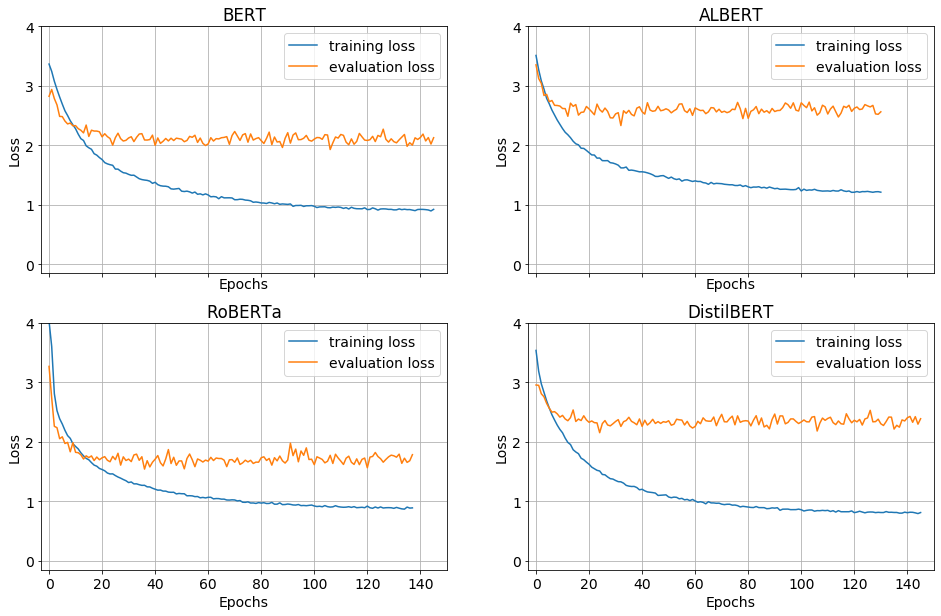

In [61]:
f, ax = plt.subplots(2, 2, figsize=(16, 10), sharex=True)
axes = plt.gca()
plt.rcParams.update({'font.size': 14})

ax[0,0].plot(bert_losses['bert_train_loss_128'])
ax[0,0].plot(bert_losses['bert_eval_loss_128'])
ax[0,0].grid()
ax[0,0].set_ylabel('Loss')
ax[0,0].set_xlabel('Epochs')
ax[0,0].set_xlim([-3,150])
ax[0,0].set_ylim([-0.15,4])
ax[0,0].title.set_text('BERT')
ax[0,0].legend(['training loss', 'evaluation loss'])
ax[1,0].plot(roberta_losses['roberta_train_loss_128'])
ax[1,0].plot(roberta_losses['roberta_eval_loss_128'])
ax[1,0].grid()
ax[1,0].set_ylabel('Loss')
ax[1,0].set_xlabel('Epochs')
ax[1,0].set_xlim([-3,150])
ax[1,0].set_ylim([-0.15,4])
ax[1,0].title.set_text('RoBERTa')
ax[1,0].legend(['training loss', 'evaluation loss'])
ax[0,1].plot(albert_losses['albert_train_loss_128'])
ax[0,1].plot(albert_losses['albert_eval_loss_128'])
ax[0,1].grid()
ax[0,1].set_ylabel('Loss')
ax[0,1].set_xlabel('Epochs')
ax[0,1].set_xlim([-3,150])
ax[0,1].set_ylim([-0.15,4])
ax[0,1].title.set_text('ALBERT')
ax[0,1].legend(['training loss', 'evaluation loss'])
ax[1,1].plot(distilbert_losses['distilbert_train_loss_128'])
ax[1,1].plot(distilbert_losses['distilbert_eval_loss_128'])
ax[1,1].grid()
ax[1,1].set_ylabel('Loss')
ax[1,1].set_xlabel('Epochs')
ax[1,1].set_xlim([-3,150])
ax[1,1].set_ylim([-0.15,4])
ax[1,1].title.set_text('DistilBERT')
ax[1,1].legend(['training loss', 'evaluation loss'])
# plt.savefig('figures/bert_baseline_loss_curve.svg')

# Extract features from transformer model <a name="extract"></a>

In [ ]:
# Compute construct similarity matrix on item corpus.
model_dir = '/home/jupyter-laengle/output_models/bert_base_noleakage_variations/distilbert_slow'
model_name = 'custom_distilbert'
transformer_embeddings = bert_sentence_embedding(corpus_unstemmed, 
                                                  model=model_name,
                                                  model_dir=model_dir, 
                                                  pool_strategy='last_layer')

# compute item similarity
item_similarity = cosine_similarity(transformer_embeddings, transformer_embeddings)

# normalize item similarities
item_similarity_norm = normalize(item_similarity, axis=1, norm='l2')

# compute construct similarity
construct_similarity = aggregate_construct_similarity(item_similarity_norm, gold_items, variable_ids,
                                                          n_similarities=2, verbose=verbose)

print(item_similarity.shape, construct_identity_gold.shape)
fpr, tpr, roc_auc, thresh = evaluate(construct_similarity, construct_identity_gold)
print("ROC AUC Score = %.6f" % roc_auc)

## Plot results as ROC curve <a name="roc"></a>

ROC curve for DistilBERT augmented and baseline

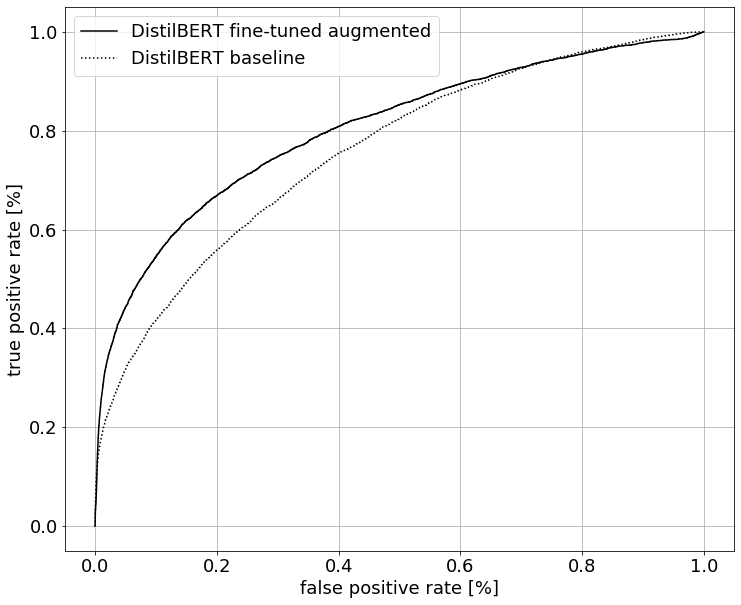

ROC AUC DistilBERT fine-tuned augmented = 0.8030
ROC AUC DistilBERT baseline = 0.7570


In [63]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(12,10))
plt.grid(True, which='major')
plt.plot(fpr_aug, tpr_aug, 'k-', label='DistilBERT fine-tuned augmented')
plt.plot(fpr_baseline, tpr_baseline, 'k:', label='DistilBERT baseline')
plt.xlabel("false positive rate [%]")
plt.ylabel("true positive rate [%]")
plt.legend()
plt.show()
print("ROC AUC DistilBERT fine-tuned augmented = %.4f" % roc_auc_aug)
print("ROC AUC DistilBERT baseline = %.4f" % roc_auc_baseline)

ROC curve for BERT fine-tuned with augmented and original data as well as baseline

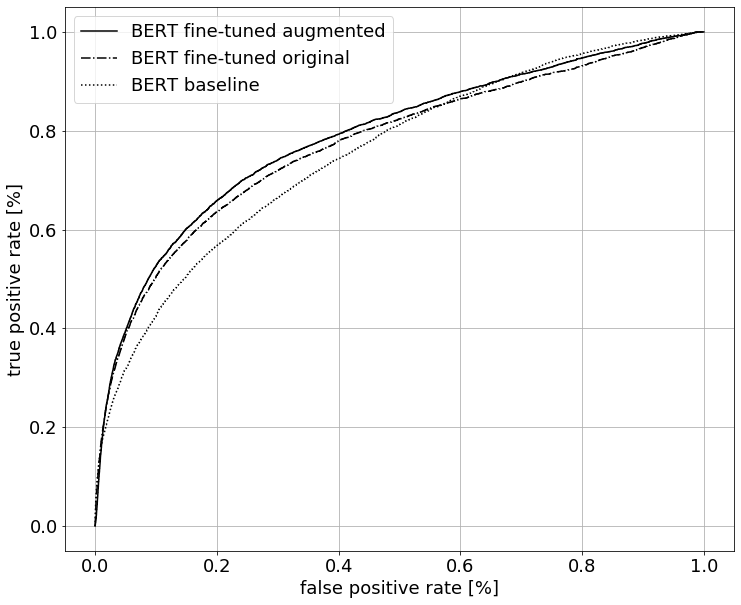

ROC AUC BERT fine-tuned augmented last layer = 0.7887
ROC AUC BERT fine-tuned original = 0.7742
ROC AUC BERT baseline = 0.7541


In [6]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(12,10))
plt.grid(True, which='major')
plt.plot(fpr_aug, tpr_aug, 'k-', label='BERT fine-tuned augmented')
plt.plot(fpr_org, tpr_org, 'k-.', label='BERT fine-tuned original')
plt.plot(fpr_baseline, tpr_baseline, 'k:', label='BERT baseline')
plt.xlabel("false positive rate [%]")
plt.ylabel("true positive rate [%]")
plt.legend()
plt.show()
print("ROC AUC BERT fine-tuned augmented last layer = %.4f" % roc_auc_aug)
print("ROC AUC BERT fine-tuned original = %.4f" % roc_auc_org)
print("ROC AUC BERT baseline = %.4f" % roc_auc_baseline)

## Compare models on item level <a name="compare"></a>

Compare impact of extracting features from BERT using items with and without stop words

**Extract features using different text corpus**

In [103]:
corpus = np.array(gold_items['Text'])
corpus_stpwrds_kept =  parse_text(np.asarray(gold_items['Text']), stemmer=None, lower=False,
                          remove_stop_words=False, return_config=False,
                          ignore_chars='', verbose=verbose)
corpus_stpwrds_rem =  parse_text(np.asarray(gold_items['Text']), stemmer=None, lower=False,
                          remove_stop_words=True, return_config=False,
                          ignore_chars='', verbose=verbose)

In [110]:
# BERT on corpus with stop words
model_dir = '/home/jupyter-laengle/output_models/bert_base_noleakage_variations/bert_base_huggingface_slow2_128_2_eval'
model_name = 'custom_bert'
sentence_embedding_bert = bert_sentence_embedding(corpus_stpwrds_kept,
                                                  model=model_name, 
                                                  model_dir=model_dir, 
                                                  pool_strategy='last_layer')

# compute item similarity
item_similarity_bert = cosine_similarity(sentence_embedding_bert, sentence_embedding_bert)

# normalize item similarities
item_similarity_bert_norm = normalize(item_similarity_bert, axis=1, norm='l2')

# compute construct similarity
construct_similarity_bert_kept, sim_df_kept = aggregate_construct_similarity_with_itemids(item_similarity_bert_norm, 
                                                                                          gold_items, variable_ids,
                                                                                          n_similarities=2, 
                                                                                          verbose=verbose)

print(item_similarity_bert.shape, construct_identity_gold.shape)
fpr_bert_kept, tpr_bert_kept, roc_auc_bert_kept, thresh_kept = evaluate(construct_similarity_bert_kept, 
                                                                        construct_identity_gold)
print("ROC AUC BERT = %.4f" % roc_auc_bert_kept)

Aggregating item to construct similarity...



(5100, 5100) (1054, 1054)
ROC AUC BERT = 0.7827


In [112]:
# BERT on corpus without stop words
model_dir = '/home/jupyter-laengle/output_models/bert_base_noleakage_variations/bert_base_huggingface_slow2_128_2_eval'
model_name = 'custom_bert'
sentence_embedding_bert = bert_sentence_embedding(corpus_stpwrds_rem, 
                                                  model=model_name, 
                                                  model_dir=model_dir, 
                                                  pool_strategy='last_layer')

# compute item similarity
item_similarity_bert = cosine_similarity(sentence_embedding_bert, sentence_embedding_bert)

# normalize item similarities
item_similarity_bert_norm = normalize(item_similarity_bert, axis=1, norm='l2')

# compute construct similarity
construct_similarity_bert_rem, sim_df_rem = aggregate_construct_similarity_with_itemids(item_similarity_bert_norm, 
                                                                                               gold_items, variable_ids,
                                                                                               n_similarities=2, 
                                                                                               verbose=verbose)

print(item_similarity_bert.shape, construct_identity_gold.shape)
fpr_bert_rem, tpr_bert_rem, roc_auc_bert_rem, thresh_rem = evaluate(construct_similarity_bert_rem, 
                                                                    construct_identity_gold)
print("ROC AUC BERT = %.4f" % roc_auc_bert_rem)

Loading custom_bert model...
Tokenizing corpus...
Create tensors...
Run model...
Aggregating item to construct similarity...



(5100, 5100) (1054, 1054)
ROC AUC BERT = 0.7887


**Extract discrepancy**

In [116]:
# determine best threshold for BERT
best_kept = tpr_bert_kept-fpr_bert_kept
print('TPR, FPR and threshold for best spot on ROC curve (stop words kept): \n ', 
      tpr_bert_kept[best_kept.argmax()], 
      fpr_bert_kept[best_kept.argmax()], 
      thresh_kept[best_kept.argmax()])

best_rem = tpr_bert_rem-fpr_bert_rem
print('TPR, FPR and threshold for best spot on ROC curve (stop words removed): \n ', 
      tpr_bert_rem[best_rem.argmax()], 
      fpr_bert_rem[best_rem.argmax()], 
      thresh_rem[best_rem.argmax()])

TPR, FPR and threshold for best spot on ROC curve (stop words kept): 
  0.6521962057767903 0.19066074160413782 0.01601358875632286
TPR, FPR and threshold for best spot on ROC curve (stop words removed): 
  0.6603999316356178 0.2013167480148612 0.015368063002824783


In [119]:
# Get discrepancy between both similarity matrices
diff_df = compare_model_threshold(construct_similarity_bert_rem, construct_similarity_bert_kept, 
                                  construct_identity_gold, thresh_1=0.015368063002824783)

# get sample with respective labels
diff_selection = diff_df.loc[(diff_df['label_1_rem']==0) & 
                             (diff_df['label_2_kept']==1) & 
                             (diff_df['gold_label']==0)]
diff_samp = diff_selection.sample(3)

# alter gold items DataFrame 
gold_items_rem = gold_items
gold_items_rem['Text_rem'] = corpus_stpwrds_rem

Print construct pairs with underlying, most similar item pair (with and without stop words)

In [120]:
for idx, row in diff_samp.iterrows():
    # get most similar item pair of two variable_ids from the diff_sample
    best_item_pair_rem = sim_df_rem[sim_df_rem['var_ids']==row[1]]
    best_item_pair_kept = sim_df_kept[sim_df_kept['var_ids']==row[1]]

    for idx3, row3 in best_item_pair_kept.iterrows():
        # print the respective items which lead to the highest cos_sim between the constructs
        print('Comparing construct pair ', row[1])
        print('- Stopwords KEPT')
        print('- Gold label: ', row[4])
        print('- Predicted label (stopwords kept): ', row[2])
        print('- Item similarity score: ', row3[1][1])
        print(row3[1][0][0], gold_items_rem.iloc[row3[1][0][0]][3])
        print(row3[1][0][1], gold_items_rem.iloc[row3[1][0][1]][3], '\n')
        
    for idx2, row2 in best_item_pair_rem.iterrows():
        # print the respective items which lead to the highest cos_sim between the constructs
        print('- Stopwords REMOVED')
        print('- Gold label: ', row[4])
        print('- Predicted label (stopwords removed): ', row[3])
        print('- Item similarity score: ', row2[1][1])
        print(row2[1][0][0], gold_items_rem.iloc[row2[1][0][0]][-1])
        print(row2[1][0][1], gold_items_rem.iloc[row2[1][0][1]][-1], '\n', '___________')

Comparing construct pair  (193, 26676)
- Stopwords KEPT
- Gold label:  0
- Predicted label (stopwords kept):  0
- Item similarity score:  0.01666869
421 Extent to which content of information exchanged (e.g., sales reporting, product information, product availability, inventory information, etc.) with partner company can be interpreted similar to information exchanged with other partners.
4361 Evaluate how you feel about the number of further choices or links on each page visited in the website. 

- Stopwords REMOVED
- Gold label:  0
- Predicted label (stopwords removed):  1
- Item similarity score:  0.014501202
419 Extent business processes interfaces partner company similar process interfaces linked channel partners - terms rules procedures.
4361 Evaluate feel number choices links page visited website. 
 ___________
Comparing construct pair  (21766, 21802)
- Stopwords KEPT
- Gold label:  0
- Predicted label (stopwords kept):  0
- Item similarity score:  0.016216729
1758 Only very spe

## Vizualize attention <a name="attention"></a>

In [191]:
def call_html():
    import IPython
    display(IPython.core.display.HTML('''
          <script src="/static/components/requirejs/require.js"></script>
          <script>
            requirejs.config({
              paths: {
                base: '/static/base',
                "d3": "https://cdnjs.cloudflare.com/ajax/libs/d3/5.7.0/d3.min",
                jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
              },
            });
          </script>
          '''))

In [ ]:
model_type = 'bert'
model_version = '/home/jupyter-laengle/output_models/bert_base_leakage_variations/bert_base_huggingface_slow2_128_2_eval'
do_lower_case = True
model = BertModel.from_pretrained(model_version)
tokenizer = BertTokenizer.from_pretrained(model_version, do_lower_case=do_lower_case)
sentence_a = 'I believe organization actively monitors content employees’ e-mail messages.' # 1867
sentence_b = 'I think people read previous posts.' # 3129
# 519 I think seller honest.
# 3533 Overall, people trustworthy.
# layer 10 head 10 (honest- trustworthy)


call_html()
show(model, model_type, tokenizer, sentence_a, sentence_b)

# LSA and GloVe by Ludwig et al. (2020) <a name="lsa"></a>

In [ ]:
# Define central parameters
validation_split = 0.5
random_state = 45
stemmer = 'porter2'
ignore_chars = '''.,:;"'!?_-/()[]{}&%0123456789'''
dtm_processing = 'tfidf_l2'  # 'count', 'l2', 'tfidf_l2', 'log_l2'
verbose = True
filepath = '/home/jupyter-laengle/data/LarsenBong2016GoldStandard.xls'

In [74]:
# Load and prepare data (will take some time). Train-validation split uses random shuffling.
random_state = 45
print("Loading data...")
data = load_data(filepath, validation_split=validation_split, random_state=random_state, verbose=verbose)
gold_items_train, gold_items_test, gold_items, pool_ids_train, pool_ids_test, variable_ids_train, variable_ids_test, variable_ids, construct_identity_gold_train, construct_identity_gold_test, construct_identity_gold = data

# Process construct item text corpus.
print("Parsing texts...")
corpus_items = parse_text(np.asarray(gold_items['Text']), stemmer=stemmer, lower=True,
                          remove_stop_words=True, return_config=False,
                          ignore_chars=ignore_chars, verbose=verbose)
corpus_items_train = parse_text(np.asarray(gold_items_train['Text']), stemmer=stemmer, lower=True,
                                remove_stop_words=True, return_config=False,
                                ignore_chars=ignore_chars, verbose=verbose)
corpus_items_test = parse_text(np.asarray(gold_items_test['Text']), stemmer=stemmer, lower=True,
                               remove_stop_words=True, return_config=False,
                               ignore_chars=ignore_chars, verbose=verbose)

# Create document-term matrices (LSA) and term-term dictionary (GloVe).
print("Creating document-term matrices (docs x terms)...")
dtm_items, terms_items = document_term_cooccurrence(corpus_items, processing=dtm_processing)
dtm_items_train, terms_items_train = document_term_cooccurrence(corpus_items_train, processing=dtm_processing)
dtm_items_test, terms_items_test = document_term_cooccurrence(corpus_items_test, processing=dtm_processing)
print("Creating term-term dictionaries (terms x terms)...")
# ttd_items is a sparse term co-occurance dict
ttd_items, dict_term_ix_items, dict_ix_term_items = term_term_cooccurrence(dtm_items, verbose=verbose)
ttd_items_train, dict_term_ix_items_train, dict_ix_term_items_train = term_term_cooccurrence(dtm_items_train, verbose=verbose)
ttd_items_test, dict_term_ix_items_test, dict_ix_term_items_test = term_term_cooccurrence(dtm_items_test, verbose=verbose)
assert variable_ids.shape[0] == construct_identity_gold.shape[0], (variable_ids.shape[0], construct_identity_gold.shape[0])
print("Done.")
print("pool_ids train/test:", pool_ids_train.shape, pool_ids_test.shape)
print("variable_ids all/train/test:", variable_ids.shape, variable_ids_train.shape, variable_ids_test.shape)
print("gold_items all/train/test:", gold_items.shape, gold_items_train.shape, gold_items_test.shape)
print("construct_identity_gold all/train/test:", construct_identity_gold.shape, construct_identity_gold_train.shape, construct_identity_gold_test.shape)

Loading data...
No construct identity gold matrix file found. Creating new file...
Parsing texts...
ValueError occurred when stemming the following words: ['dms', 'm', 'dp', 'dw', 'typically', 'q', 'type', 's', 'hr', 'clients', 'tmt', 'd', 'try', 't', 'trying', 'cpc', 'prior', 'client', 'g'] 

ValueError occurred when stemming the following words: ['m', 'dp', 'dw', 'typically', 'q', 'type', 's', 'hr', 'clients', 'tmt', 'd', 'try', 'cpc', 'client', 'g'] 

ValueError occurred when stemming the following words: ['dms', 'm', 'dw', 's', 'tmt', 't', 'trying', 'prior', 'client', 'g'] 

Creating document-term matrices (docs x terms)...
Creating term-term dictionaries (terms x terms)...



Done.
pool_ids train/test: (26,) (26,)
variable_ids all/train/test: (99,) (56,) (43,)
gold_items all/train/test: (451, 9) (234, 9) (217, 9)
construct_identity_gold all/train/test: (99, 99) (56, 56) (43, 43)


**LSA**

In [ ]:
# Compute construct similarity matrix with LSA on item corpus.
print("Computing construct similarity matrix with LSA...")
use_doc_vectors_lsa = True  # use document vectors
lsa_aggregation = False     # if not document vectors, use top 2 (n2) aggregation or vector averaging
# LSA as dimensionality reduction. Document-term-matrix turns into Document-component-matrix (n_components=300)
vector_dict_lsa, item_vectors_lsa = train_vectors_lsa(dtm_items, n_components=300, return_doc_vectors=True)
if use_doc_vectors_lsa:
    # Use document-vectors.
    item_similarity_lsa = pd.DataFrame(np.asmatrix(item_vectors_lsa) * np.asmatrix(item_vectors_lsa).T,
                                       index=gold_items, columns=gold_items)
else:
    term_vectors_lsa = term_vectors_from_dict(vector_dict_lsa, terms_items, normalize=True, verbose=verbose)
    if lsa_aggregation:
        # Term to item vector aggregation.
        item_similarity_lsa = aggregate_item_similarity(dtm_items, term_vectors_lsa, n_similarities=2, verbose=verbose)
    else:
        # Term vector averaging.
        item_vectors_lsa_avg = vector_average(dtm_items, term_vectors_lsa, weighting=False)
        item_similarity_lsa = pd.DataFrame(np.asarray(
            np.asmatrix(item_vectors_lsa_avg) * np.asmatrix(item_vectors_lsa_avg).T),
            index=item_vectors_lsa_avg.index.values, columns=item_vectors_lsa_avg.index.values)
construct_similarity_lsa = aggregate_construct_similarity(item_similarity_lsa, gold_items, variable_ids,
                                                          n_similarities=2, verbose=verbose)
print(construct_similarity_lsa.shape, construct_identity_gold.shape)
fpr_lsa, tpr_lsa, roc_auc_lsa = evaluate(construct_similarity_lsa, construct_identity_gold)
print("ROC AUC LSA = %.3f" % roc_auc_lsa)

Computing construct similarity matrix with LSA...
Aggregating item to construct similarity...


100%|██████████| 1053/1053 [05:44<00:00,  3.06it/s]


(1054, 1054) (1054, 1054)
ROC AUC LSA = 0.823


**GloVe**

In [26]:
# Compute construct similarity matrix with self-trained GloVe on FULL item corpus.
print("Computing construct similarity matrix with self-trained GloVe...")
glove_aggregation = False  # aggregate items by top-n similarity like with constructs
vector_dict_trglove, loss_glove_items = train_vectors_glove(ttd_items, n_components=300, alpha=0.4, x_max=10.0,
                                                            step_size=0.2, n_epochs=100, batch_size=64, workers=4,
                                                            verbose=False)  # Train vectors.
vector_dict_trglove = {dict_ix_term_items[key]: value for key, value in
                       vector_dict_trglove.items()}  # Translate indices.
term_vectors_trglove = term_vectors_from_dict(vector_dict_trglove, terms_items, normalize=True, verbose=True)
if glove_aggregation:
    item_similarity_trglove = aggregate_item_similarity(dtm_items, term_vectors_trglove, n_similarities=2,
                                                        verbose=verbose)
else:
    item_vectors_trglove = vector_average(dtm_items, term_vectors_trglove, weighting=False)
    # Compute item similarity. Set negative values to 0, unknown source.
    item_similarity_trglove = pd.DataFrame(np.asarray(
        np.asmatrix(item_vectors_trglove) * np.asmatrix(item_vectors_trglove).T).clip(min=0),
                                           index=item_vectors_trglove.index.values,
                                           columns=item_vectors_trglove.index.values)
construct_similarity_trglove = aggregate_construct_similarity(item_similarity_trglove, gold_items, variable_ids,
                                                              n_similarities=2, verbose=verbose)
fpr_trglove, tpr_trglove, roc_auc_trglove = evaluate(construct_similarity_trglove, construct_identity_gold)
time.sleep(0.5)
print("ROC AUC self-trained GloVe on FULL corpus = %.3f" % roc_auc_trglove)

Computing construct similarity matrix with self-trained GloVe...
Created term vectors from dictionary. 0 OOV words.
Aggregating item to construct similarity...



ROC AUC self-trained GloVe on FULL corpus = 0.829


# LSA and GloVe using augmented text corpus <a name="lsa_aug"></a>

In [35]:
random_state = 45
print("Loading data...")
data = load_data(filepath, validation_split=validation_split, random_state=random_state, verbose=verbose)
gold_items_train, gold_items_test, gold_items, pool_ids_train, pool_ids_test, variable_ids_train, variable_ids_test, variable_ids, construct_identity_gold_train, construct_identity_gold_test, construct_identity_gold = data

gold_items = augment_glove_data(gold_items)
gold_items = drop_empty_text(gold_items)

# Process construct item text corpus.
print("Parsing texts...")
corpus_items = parse_text(np.asarray(gold_items['Text']), stemmer=stemmer, lower=True,
                          remove_stop_words=True, return_config=False,
                          ignore_chars=ignore_chars, verbose=verbose)

# Create document-term matrices (LSA) and term-term dictionary (GloVe).
print("Creating document-term matrices (docs x terms)...")
dtm_items, terms_items = document_term_cooccurrence(corpus_items, processing=dtm_processing)
print("Creating term-term dictionaries (terms x terms)...")
# ttd_items is a sparse term co-occurance dict
ttd_items, dict_term_ix_items, dict_ix_term_items = term_term_cooccurrence(dtm_items, verbose=verbose)

assert variable_ids.shape[0] == construct_identity_gold.shape[0], (variable_ids.shape[0], construct_identity_gold.shape[0])
print("Done.")
print('len of gold_items, corpus_items and dtm_items: ', len(gold_items), len(corpus_items), len(dtm_items))
print("pool_ids train/test:", pool_ids_train.shape, pool_ids_test.shape)
print("variable_ids all/train/test:", variable_ids.shape, variable_ids_train.shape, variable_ids_test.shape)
print("gold_items all/train/test:", gold_items.shape, gold_items_train.shape, gold_items_test.shape)
print("construct_identity_gold all/train/test:", construct_identity_gold.shape, construct_identity_gold_train.shape, construct_identity_gold_test.shape)

Loading data...
No construct identity gold matrix file found. Creating new file...



Parsing texts...
ValueError occurred when stemming the following words: ['typical', 'threats', 'fbi', 'g', 'c', 'nt', 'pws', 'wk', 'f', '¹⁄₂', 'priorities', 'dw', 'dvd', 'cycles', 'flies', 'crc', 't', 'v', 'style', 'x', 'st', 'm', 'cycle', 'n', 'threat', 'tmt', 'tv', 'stylish', 'cbt', 'trial', 'client', 'x’s', 'physics', 'd', 'typically', 'l', 'clients', 'science', 'scientific', 'ysm', 'physical', 'pseudo', 'physically', 'try', 'nf', 'ms', 'micros', 'tried', 'k', 'priority', 'cds', 'threatened', 'trying', 'dr', 'dp', 'prior', 'pc', 'mds', 's', 'pcs', 'sf', 'xml', 'npd', 'h', 'th', 'p', 'crm', 'www', 'dvds', 'hr', 'dms', 'cpc', 'styles', 'type', 'q', 'cd', 'ss', 'dfd', 'types', 'r'] 

Creating document-term matrices (docs x terms)...
Creating term-term dictionaries (terms x terms)...



Done.
len of gold_items, corpus_items and dtm_items:  25171 25171 25171
pool_ids train/test: (173,) (174,)
variable_ids all/train/test: (1054,) (471,) (533,)
gold_items all/train/test: (25171, 9) (2112, 9) (2639, 9)
construct_identity_gold all/train/test: (1054, 1054) (471, 471) (533, 533)


**LSA**

In [ ]:
# Compute construct similarity matrix with LSA on augmented item corpus.
print("Computing construct similarity matrix with LSA...")
use_doc_vectors_lsa = True  # use document vectors
lsa_aggregation = False     # if not document vectors, use top 2 (n2) aggregation or vector averaging
# LSA as dimensionality reduction. Document-term-matrix turns into Document-component-matrix (n_components=300)
vector_dict_lsa, item_vectors_lsa = train_vectors_lsa(dtm_items, n_components=300, return_doc_vectors=True)
if use_doc_vectors_lsa:
    # Use document-vectors.
    item_similarity_lsa = pd.DataFrame(np.asmatrix(item_vectors_lsa) * np.asmatrix(item_vectors_lsa).T,
                                       index=gold_items, columns=gold_items)
else:
    term_vectors_lsa = term_vectors_from_dict(vector_dict_lsa, terms_items, normalize=True, verbose=verbose)
    if lsa_aggregation:
        # Term to item vector aggregation.
        item_similarity_lsa = aggregate_item_similarity(dtm_items, term_vectors_lsa, n_similarities=2, verbose=verbose)
    else:
        # Term vector averaging.
        item_vectors_lsa_avg = vector_average(dtm_items, term_vectors_lsa, weighting=False)
        item_similarity_lsa = pd.DataFrame(np.asarray(
            np.asmatrix(item_vectors_lsa_avg) * np.asmatrix(item_vectors_lsa_avg).T),
            index=item_vectors_lsa_avg.index.values, columns=item_vectors_lsa_avg.index.values)
construct_similarity_lsa = aggregate_construct_similarity(item_similarity_lsa, gold_items, variable_ids,
                                                          n_similarities=2, verbose=verbose)
print(construct_similarity_lsa.shape, construct_identity_gold.shape)
fpr_lsa, tpr_lsa, roc_auc_lsa = evaluate(construct_similarity_lsa, construct_identity_gold)
print("ROC AUC LSA = %.3f" % roc_auc_lsa)

**GloVe**

In [ ]:
print("Computing construct similarity matrix with self-trained GloVe...")
glove_aggregation = False  # aggregate items by top-n similarity like with constructs
vector_dict_trglove, loss_glove_items = train_vectors_glove(ttd_items, n_components=300, alpha=0.4, x_max=10.0,
                                                            step_size=0.15, n_epochs=50, batch_size=64, workers=4,
                                                            verbose=False)  # Train vectors.
vector_dict_trglove = {dict_ix_term_items[key]: value for key, value in
                       vector_dict_trglove.items()}  # Translate indices.
term_vectors_trglove = term_vectors_from_dict(vector_dict_trglove, terms_items, normalize=True, verbose=True)
if glove_aggregation:
    item_similarity_trglove = aggregate_item_similarity(dtm_items, term_vectors_trglove, n_similarities=2,
                                                        verbose=verbose)
else:
    item_vectors_trglove = vector_average(dtm_items, term_vectors_trglove, weighting=False)
    # Compute item similarity. Set negative values to 0, unknown source.
    item_similarity_trglove = pd.DataFrame(np.asarray(
        np.asmatrix(item_vectors_trglove) * np.asmatrix(item_vectors_trglove).T).clip(min=0),
                                           index=item_vectors_trglove.index.values,
                                           columns=item_vectors_trglove.index.values)

construct_similarity_trglove, sim_df_glove = aggregate_construct_similarity_with_itemids(item_similarity_trglove, 
                                                                                         gold_items, variable_ids,
                                                                                         n_similarities=2,  
                                                                                         verbose=verbose)
fpr_trglove, tpr_trglove, roc_auc_trglove, thresh_trglove = evaluate(construct_similarity_trglove, construct_identity_gold)
time.sleep(0.5)
print("ROC AUC self-trained GloVe on FULL corpus = %.4f" % roc_auc_trglove)

# Appendix<a name="app"></a>

Compare tokenization of gold items with SciBERT and BERT

In [609]:
sent = bert_sentence_embedding(corpus, model='scibert')
sent = bert_sentence_embedding(corpus, model='BERT')

Loading scibert model...
Tokenizing corpus...
Create tensors...
Run model...
Loading BERT model...
Tokenizing corpus...
Create tensors...
Run model...


In [614]:
count_sci = 0
for sent in tqdm.tqdm(tokenized_scibert):
    for j in sent:
        if '##' in j:
            count_sci += 1
        else:
            continue

count_bert = 0
for sent in tqdm.tqdm(tokenized_bert):
    for j in sent:
        if '##' in j:
            count_bert += 1
        else:
            continue
            
print('Amount of split tokens using SciBERT: ',count_sci)
print('Amount of split tokens using BERT: ',count_bert)


Amount of split tokens using SciBERT:  2307
Amount of split tokens using BERT:  2443
